baseline 코드에서 크게 수정을 가하지 않고 필요한 부분을 수정하는 방식으로 진행했습니다.

실제 작업은 시간 절약을 위해 colab의 여러 session에 fold를 나눠서 학습했습니다.

공유드린 코드는 한번에 학습이 가능하도록 수정했습니다.

(한개의 fold 학습 코드를 수정했기 때문에 출력창의 결과는 참고만 해주세요.)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 불러오기


구글 드라이브 내에서 작업하면 읽기/쓰기 속도가 느려서 데이터를 colab의 루트 디렉토리로 옮겨서 작업했습니다.

In [2]:
cd /content/drive/MyDrive/Dirty_Mnist

/content/drive/MyDrive/Dirty_Mnist


In [ ]:
from google.colab import output
!mkdir /data
!cp data/'2차 배포.zip' /data
!unzip /data/'2차 배포.zip' -d /data
!unzip /data/dirty_mnist_2nd.zip -d /data/train
!unzip /data/test_dirty_mnist_2nd.zip -d /data/test
!unzip /data/mnist_data.zip -d /data/mnist_data
output.clear()

## 2. Library Import

In [4]:
!pip -q install timm
!pip -q install --upgrade albumentations

     |████████████████████████████████| 245kB 9.8MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 952kB 19.2MB/s 
     |████████████████████████████████| 37.6MB 95kB/s 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

import timm
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
import imgaug
import random

In [6]:
class config:
    seed = 42
    device = "cuda"    
        
    lr = 1e-3
    epochs = 50
    train_batch_size = 24
    valid_batch_size = 24
    test_batch_size = 24
    num_workers = 8
    tta = True
    tta_count = 32

    folds = 5
    
    IMG_SIZE = 380

    TRAIN_DATA_PATH = '/data/train/'
    TEST_DATA_PATH = '/data/test/'
    ANSWER_FILE = '/data/dirty_mnist_2nd_answer.csv'

    ADAM_MODEL_PATH = './models/adam_model/'
    SAM_MODEL_PATH = './models/sam_model/'
    ADAM_MODEL_PREFIX = 'eff_b3_adam_ind'
    SAM_MODEL_PREFIX = 'eff_b3_sam_ind'

    SAMPLE_SUBMISSION_FILE = '/data/sample_submission.csv'
    SUBMISSION_FILE = 'submission.csv'

In [7]:
try:
    if not os.path.exists(config.ADAM_MODEL_PATH):
        os.makedirs(config.ADAM_MODEL_PATH)
    if not os.path.exists(config.SAM_MODEL_PATH):
        os.makedirs(config.SAM_MODEL_PATH)
except OSError:
    print ('Error: Creating directory. ' +  directory)

In [8]:
# device 설정
device = torch.device(config.device if torch.cuda.is_available() else "cpu")

# seed 설정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    imgaug.random.seed(seed)

seed_everything(config.seed)

## 3. Dataset 구성

데이터셋의 특성상 여러 알파벳이 산발적으로 놓여져 있어서 일반적인 cutmix를 사용하기 어렵다고 생각했습니다.

그래서 자기 이미지의 두 부분을 잘라 서로 교환해 붙이는 `self_cut_mix` 함수를 만들어 augmentation 단계에서 사용했습니다.

In [9]:
def self_cut_mix(img):
    transformed_img = img.copy()
    l = random.randrange(img.shape[0] // 8, img.shape[0] // 2 + 1)
    
    # cut
    if random.choice([True, False]):
        i1 = random.randrange(l, img.shape[0] - l + 1)
        j1 = random.randrange(0, img.shape[0] - l + 1)
        i2 = random.randrange(0, i1 - l + 1)
        j2 = random.randrange(0, img.shape[0] - l + 1)
    else:
        i1 = random.randrange(0, img.shape[0] - l + 1)
        j1 = random.randrange(l, img.shape[0] - l + 1)
        i2 = random.randrange(0, img.shape[0] - l + 1)
        j2 = random.randrange(0, j1 - l + 1)
        
    p1 = img[i1:i1+l, j1:j1+l].copy()
    p2 = img[i2:i2+l, j2:j2+l].copy()
    
    # rotate piece
    random_rotate_90 = A.RandomRotate90(p=1)
    p1 = random_rotate_90(image=p1)["image"]
    p2 = random_rotate_90(image=p2)["image"]
    
    # mix
    if random.choice([True, False]):
        transformed_img[i1:i1+l, j1:j1+l] = p2
        transformed_img[i2:i2+l, j2:j2+l] = p1
    else:
        transformed_img[i1:i1+l, j1:j1+l] = p1
        transformed_img[i2:i2+l, j2:j2+l] = p2

    return transformed_img

class SelfCutMix(ImageOnlyTransform):
    def __init__(
        self,
        always_apply=False,
        p=1
    ):
        super(SelfCutMix, self).__init__(always_apply, p)
    
    def apply(self, img, **params):
        return self_cut_mix(img)

In [10]:
dirty_mnist_answer = pd.read_csv(config.ANSWER_FILE)
# dirty_mnist라는 디렉터리 속에 들어있는 파일들의 이름을 
# namelist라는 변수에 저장
namelist = sorted(os.listdir(config.TRAIN_DATA_PATH))

# numpy를 tensor로 변환하는 ToTensor 정의
class ToTensor(object):
    """numpy array를 tensor(torch)로 변환합니다."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.FloatTensor(image),
                'label': torch.FloatTensor(label)}
# to_tensor 선언
to_tensor = T.Compose([
                        ToTensor()
                    ])

class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms=to_tensor,  # 미리 선언한 to_tensor를 transforms로 받음
                 augmentations=None):
        
        self.dir_path = dir_path  # 데이터의 이미지가 저장된 디렉터리 경로
        self.meta_df = meta_df  # 데이터의 인덱스와 정답지가 들어있는 DataFrame

        self.transforms = transforms  # Transform
        self.augmentations = augmentations  # Augmentation
        
    def __len__(self):
        return len(self.meta_df)
    
    def __getitem__(self, index):
        # 폴더 경로 + 이미지 이름 + .png => 파일의 경로
        # 참고) "12".zfill(5) => 000012
        #       "146".zfill(5) => 000145
        # cv2.IMREAD_GRAYSCALE : png파일을 채널이 1개인 GRAYSCALE로 읽음
        image = cv2.imread(self.dir_path +\
                           str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
                           cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image, dsize=(config.IMG_SIZE, config.IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        # augmentation 적용
        if self.augmentations:
            augmentations = A.Compose([
                A.RandomRotate90(p=1),
                A.GridDistortion(p=0.8),
                SelfCutMix(p=1),
                A.CoarseDropout(p=0.8, max_holes=4, max_height=32, max_width=32, min_holes=1, min_height=16, min_width=16, fill_value=0),
                A.GaussNoise(p=0.75),
            ])
            image = augmentations(image=image)['image']
        
        # 0 ~ 255의 값을 갖고 크기가 (256,256)인 numpy array를
        # 0 ~ 1 사이의 실수를 갖고 크기가 (256,256,1)인 numpy array로 변환
        image = (image/255).astype('float')[..., np.newaxis]

        # 정답 numpy array생성(존재하면 1 없으면 0)
        label = self.meta_df.iloc[index, 1:].values.astype('float')
        sample = {'image': image, 'label': label}

        # transform 적용
        # numpy to tensor
        if self.transforms:
            sample = self.transforms(sample)

        # sample 반환
        return sample

## 4. 모델 구성

모델은 일반적인 `Adam optimizer`를 사용한 모델과 코드 공유 게시판에 있는 `Sharpness-Aware Minimization(SAM)`을 적용한 모델 두개를 만들어 각각 학습한 뒤 앙상블 했습니다.

Backbone 모델은 `EfficientNet-b3`를 사용했습니다.

출력 부분에서 각각의 class를 더 잘 분류하도록 `class마다 dense layer`를 붙였습니다.

In [11]:
class AdamModel(nn.Module):
    def __init__(self):
        super(AdamModel, self).__init__()
        self.conv2d = nn.Conv2d(1, 3, 3, stride=1, padding=1)
        self.efn_b3 = timm.create_model('efficientnet_b3', pretrained=True, num_classes=1024)
        self.fc = nn.ModuleList([nn.Linear(1024, 1) for i in range(26)])

        nn.init.xavier_uniform_(self.conv2d.weight)
        for i in range(26):
            nn.init.xavier_uniform_(self.fc[i].weight)

    def forward(self, x):
        x = F.relu(self.conv2d(x))
        x = F.relu(self.efn_b3(x))
        xs = []
        for i in range(26):
            xs.append(self.fc[i](x))
        x = torch.cat(xs, dim=1)
        x = torch.sigmoid(x)
        return x

In [ ]:
class SAM_Model(nn.Module):
    def __init__(self):
        super(SAM_Model, self).__init__()
        self.conv2d = nn.Conv2d(1, 3, 3, stride=1, padding=1)
        self.efn_b3 = timm.create_model('efficientnet_b3', pretrained=True, num_classes=1024)
        self.fc = nn.ModuleList([nn.Linear(1024, 1) for i in range(26)])

        nn.init.xavier_uniform_(self.conv2d.weight)
        for i in range(26):
            nn.init.xavier_uniform_(self.fc[i].weight)

    def forward(self, x):
        x = F.gelu(self.conv2d(x))
        x = F.gelu(self.efn_b3(x))
        xs = []
        for i in range(26):
            xs.append(self.fc[i](x))
        x = torch.cat(xs, dim=1)
        x = torch.sigmoid(x)
        return x

## 5. 모델 학습

SAM을 적용하고 stepLR의 gamma를 조정한 것 외에는 baseline과 거의 동일합니다.

### Adam Model Train

In [ ]:
# cross validation을 적용하기 위해 KFold 생성
from sklearn.model_selection import KFold
kfold = KFold(n_splits=config.folds, shuffle=True, random_state=0)

# dirty_mnist_answer에서 train_idx와 val_idx를 생성
best_models = []  # 폴드별로 가장 validation acc가 높은 모델 저장
for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer),1):
    print(f'[fold: {fold_index}]')
    '''
    실제로 colab에서 학습할 때에는 시간 절약을 위해 fold별로 여러 session을 열어두고 병렬 작업을 수행했습니다.
    각각의 fold 작업에서 동일한 seed로 작업이 진행되기 때문에 이 코드에서 제출 결과를 재현하기 위해서는
    seed 초기화가 필요할 수 있습니다.

    seed_everything(config.seed)
    ''' 
    # cuda cache 초기화
    torch.cuda.empty_cache()

    #train fold, validation fold 분할
    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer  = dirty_mnist_answer.iloc[val_idx]

    #Dataset 정의
    train_dataset = DatasetMNIST(config.TRAIN_DATA_PATH, train_answer, augmentations=True)
    valid_dataset = DatasetMNIST(config.TRAIN_DATA_PATH, test_answer)

    #DataLoader 정의
    train_data_loader = DataLoader(
        train_dataset,
        batch_size = config.train_batch_size,
        shuffle = False,
        num_workers = config.num_workers
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = config.valid_batch_size,
        shuffle = False,
        num_workers = config.num_workers
    )

    # 모델 선언
    model = AdamModel()
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)  # gpu에 모델 할당

    # 훈련 옵션 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.85)
    criterion = torch.nn.BCELoss()

    # 훈련 시작
    valid_acc_max = 0
    early_stop_count = 0
    for epoch in range(config.epochs):
        # 1개 epoch 훈련
        train_acc_list = []
        with tqdm(train_data_loader,#train_data_loader를 iterative하게 반환
                total=train_data_loader.__len__(), # train_data_loader의 크기
                unit="batch") as train_bar:# 한번 반환하는 smaple의 단위는 "batch"
            for sample in train_bar:
                train_bar.set_description(f"Train Epoch {epoch}")
                # 갱신할 변수들에 대한 모든 변화도를 0으로 초기화
                # 참고)https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                # tensor를 gpu에 올리기 
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 train 모드로 설정
                model.train()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.set_grad_enabled(True):
                    # 모델 예측
                    probs  = model(images)
                    # loss 계산
                    loss = criterion(probs, labels)
                    # 중간 노드의 gradient로
                    # backpropagation을 적용하여
                    # gradient 계산
                    loss.backward()
                    # weight 갱신
                    optimizer.step()

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)

                # 현재 progress bar에 현재 미니배치의 loss 결과 출력
                train_bar.set_postfix(train_loss= loss.item(),
                                        train_acc = train_acc)
                

        # 1개 epoch학습 후 Validation 점수 계산
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit="batch") as valid_bar:
            for sample in valid_bar:
                valid_bar.set_description(f"Valid Epoch {epoch}")
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 eval모드로 설정
                model.eval()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.no_grad():
                    # validation loss만을 계산
                    probs  = model(images)
                    valid_loss = criterion(probs, labels)

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                        valid_acc = valid_acc)
            
        # Learning rate 조절
        lr_scheduler.step()

        # 모델 저장
        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            early_stop_count = 0
            best_model = model
            MODEL = config.ADAM_MODEL_PREFIX
            # 모델을 저장할 구글 드라이브 경로
            path = config.ADAM_MODEL_PATH
            torch.save(best_model, f'{path}{fold_index}_{MODEL}.pth')
        else:
            early_stop_count += 1
            if early_stop_count > 5:
                print(f'early stopped at epoch: {epoch}')
                break

    # 폴드별로 가장 좋은 모델 저장
    best_models.append(best_model)

### SAM Model Train

In [12]:
### https://github.com/davda54/sam

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [13]:
# dirty_mnist_answer에서 train_idx와 val_idx를 생성
for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer),1):
    print(f'[fold: {fold_index}]')
    '''
    실제로 colab에서 학습할 때에는 시간 절약을 위해 fold별로 여러 session을 열어두고 병렬 작업을 수행했습니다.
    각각의 fold 작업에서 동일한 seed로 작업이 진행되기 때문에 이 코드에서 제출 결과를 재현하기 위해서는
    seed 초기화가 필요할 수 있습니다.

    seed_everything(config.seed)
    ''' 
    # cuda cache 초기화
    torch.cuda.empty_cache()

    #train fold, validation fold 분할
    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer  = dirty_mnist_answer.iloc[val_idx]

    #Dataset 정의
    train_dataset = DatasetMNIST(config.TRAIN_DATA_PATH, train_answer, augmentations=True)
    valid_dataset = DatasetMNIST(config.TRAIN_DATA_PATH, test_answer)

    #DataLoader 정의
    train_data_loader = DataLoader(
        train_dataset,
        batch_size = config.train_batch_size,
        shuffle = False,
        num_workers = config.num_workers
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = config.valid_batch_size,
        shuffle = False,
        num_workers = config.num_workers
    )

    # 모델 선언
    model = SAM_Model()
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)# gpu에 모델 할당

    # 훈련 옵션 설정
    base_optimizer = torch.optim.Adam
    optimizer = SAM(model.parameters(), base_optimizer, lr=config.lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.85)
    criterion = torch.nn.BCELoss()

    # 훈련 시작
    valid_acc_max = 0
    early_stop_count = 0
    for epoch in range(config.epochs):
        # 1개 epoch 훈련
        train_acc_list = []
        with tqdm(train_data_loader,#train_data_loader를 iterative하게 반환
                total=train_data_loader.__len__(), # train_data_loader의 크기
                unit="batch") as train_bar:# 한번 반환하는 smaple의 단위는 "batch"
            for sample in train_bar:
                train_bar.set_description(f"Train Epoch {epoch}")
                # 갱신할 변수들에 대한 모든 변화도를 0으로 초기화
                # 참고)https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                # tensor를 gpu에 올리기 
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 train 모드로 설정
                model.train()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.set_grad_enabled(True):
                    # 모델 예측
                    probs  = model(images)
                    # loss 계산
                    loss = criterion(probs, labels)
                    # 중간 노드의 gradient로
                    # backpropagation을 적용하여
                    # gradient 계산
                    loss.backward()
                    
                    # sam optimizer first_step
                    optimizer.first_step(zero_grad=True)
                    
                    # sam optimizer second_step
                    criterion(model(images), labels).backward()   
                    optimizer.second_step(zero_grad=True)

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)

                # 현재 progress bar에 현재 미니배치의 loss 결과 출력
                train_bar.set_postfix(train_loss= loss.item(),
                                        train_acc = train_acc)
                

        # 1개 epoch학습 후 Validation 점수 계산
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit="batch") as valid_bar:
            for sample in valid_bar:
                valid_bar.set_description(f"Valid Epoch {epoch}")
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 eval모드로 설정
                model.eval()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.no_grad():
                    # validation loss만을 계산
                    probs  = model(images)
                    valid_loss = criterion(probs, labels)

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                        valid_acc = valid_acc)
            
        # Learning rate 조절
        lr_scheduler.step()

        # 모델 저장
        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            early_stop_count = 0
            best_model = model
            MODEL = config.SAM_MODEL_PREFIX
            # 모델을 저장할 구글 드라이브 경로
            path = config.SAM_MODEL_PATH
            torch.save(best_model, f'{path}{fold_index}_{MODEL}.pth')
        else:
            early_stop_count += 1
            if early_stop_count > 5:
                print(f'early stopped at epoch: {epoch}')
                break

    # 폴드별로 가장 좋은 모델 저장
    best_models.append(best_model)

[fold: 1]


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth
Valid Epoch 0: 100%|██████████| 417/417 [00:44<00:00,  9.27batch/s, valid_acc=0.67, valid_loss=0.592]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Valid Epoch 46: 100%|██████████| 417/417 [00:46<00:00,  8.87batch/s, valid_acc=0.943, valid_loss=0.164]

early stopped at epoch: 46


## 6. 학습 결과 확인

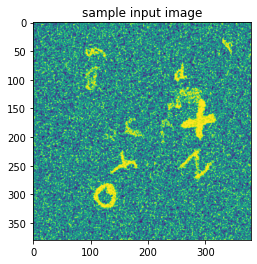

예측값 :  Index(['b', 'd', 'f', 'h', 'j', 'm', 'n', 'o', 'q', 'r', 't', 'w', 'x', 'z'], dtype='object')
정답값 :  Index(['b', 'd', 'f', 'h', 'j', 'o', 'q', 'r', 't', 'w', 'x', 'z'], dtype='object')


In [14]:
# gpu에 올라가 있는 tensor -> cpu로 이동 -> numpy array로 변환
sample_images = images.cpu().detach().numpy()
sample_prob = probs
sample_labels = labels

idx = 1
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ',dirty_mnist_answer.columns[1:][sample_prob[idx] > 0.5])
print('정답값 : ', dirty_mnist_answer.columns[1:][sample_labels[idx] > 0.5])

## 7. Inference

Adam 모델과 SAM 모델 결과에 `Test Time Augmentation(TTA)`를 적용하고 `앙상블`했습니다.

In [ ]:
# seed_everything(config.seed)

#test Dataset 정의
sample_submission = pd.read_csv(config.SAMPLE_SUBMISSION_FILE)
test_dataset = DatasetMNIST(config.TEST_DATA_PATH, sample_submission)
test_data_loader = DataLoader(
    test_dataset,
    batch_size = config.test_batch_size,
    shuffle = False,
    num_workers = config.num_workers,
    drop_last = False
)

### Adam Model Inference

In [ ]:
model = AdamModel()
model_files = os.listdir(config.ADAM_MODEL_PATH)
best_models = [torch.load(config.ADAM_MODEL_PATH + model_file) for model_file in model_files]

In [ ]:
predictions_list = []
# 배치 단위로 추론
prediction_df = pd.read_csv(config.SAMPLE_SUBMISSION_FILE)

# 5개의 fold마다 가장 좋은 모델을 이용하여 예측
for model_index, model in enumerate(best_models):
    print(f'[model: {model_files[model_index]}]')
    if config.tta:
        count = config.tta_count
    else:
        count = 1
    for c in range(count):
        # 0으로 채워진 array 생성
        prediction_array = np.zeros([prediction_df.shape[0],
                                    prediction_df.shape[1] -1])
        with tqdm(test_data_loader,
                total=test_data_loader.__len__(),
                unit="batch") as test_bar:
            for idx, sample in enumerate(test_bar):
                with torch.no_grad():
                    # 추론
                    model.eval()
                    images = sample['image']
                    images = images.to(device)
                    probs = model(images)
                    probs = probs.cpu().detach().numpy()

                    # 예측 결과를 
                    # prediction_array에 입력
                    batch_index = config.test_batch_size * idx
                    prediction_array[batch_index: batch_index + images.shape[0],:]\
                                = probs
                            
        # 채널을 하나 추가하여 list에 append
        predictions_list.append(prediction_array[...,np.newaxis])

### SAM Model Inference

In [ ]:
model = SAM_Model()
model_files = os.listdir(config.SAM_MODEL_PATH)
best_models = [torch.load(config.SAM_MODEL_PATH + model_file) for model_file in model_files]

In [ ]:
# 5개의 fold마다 가장 좋은 모델을 이용하여 예측
for model_index, model in enumerate(best_models):
    print(f'[model: {model_files[model_index]}]')
    if config.tta:
        count = config.tta_count
    else:
        count = 1
    for c in range(count):
        # 0으로 채워진 array 생성
        prediction_array = np.zeros([prediction_df.shape[0],
                                    prediction_df.shape[1] -1])
        with tqdm(test_data_loader,
                total=test_data_loader.__len__(),
                unit="batch") as test_bar:
            for idx, sample in enumerate(test_bar):
                with torch.no_grad():
                    # 추론
                    model.eval()
                    images = sample['image']
                    images = images.to(device)
                    probs = model(images)
                    probs = probs.cpu().detach().numpy()

                    # 예측 결과를 
                    # prediction_array에 입력
                    batch_index = config.test_batch_size * idx
                    prediction_array[batch_index: batch_index + images.shape[0],:]\
                                = probs
                            
        # 채널을 하나 추가하여 list에 append
        predictions_list.append(prediction_array[...,np.newaxis])

## 8. 제출파일 생성

In [ ]:
# axis = 2를 기준으로 평균
predictions_array = np.concatenate(predictions_list, axis = 2)
predictions_mean = predictions_array.mean(axis = 2)

# 평균 값이 0.5보다 클 경우 1 작으면 0
predictions_mean = (predictions_mean > 0.5) * 1
predictions_mean

In [ ]:
sample_submission = pd.read_csv(config.SAMPLE_SUBMISSION_FILE)
sample_submission.iloc[:,1:] = predictions_mean
sample_submission.to_csv(config.SUBMISSION_FILE, index = False)
sample_submission